# Technical Report: Marine Engine Failure Analysis

---

## 1. Introduction
Marine transportation depends on reliable engine performance. Failures not only disrupt operations but may also endanger crew and cargo. With increasing data availability from onboard sensors, there is a strong opportunity to apply data-driven approaches for **failure prediction** and **preventive maintenance planning**.

This report aims to:
- Detect abnormal engine behavior that could indicate impending failure.
- Quantify engine stress and performance through derived metrics.
- Provide maintenance stakeholders with actionable insights through structured analysis.

---

## 2. Problem Statement

### 2.1 Challenges
- Detecting abnormal patterns in telemetry data (temperature, oil pressure, vibration).  
- Identifying early warning signs of failures across multiple engine types.  
- Minimizing false alarms in anomaly detection.  
- Communicating findings effectively for maintenance decision-making.  

### 2.2 Objectives
- Perform exploratory data analysis on engine telemetry.  
- Clean and preprocess data for reliability.  
- Engineer features to capture mechanical stress.  
- Apply anomaly detection techniques to identify high-risk engines.  
- Summarize results into interpretable, actionable recommendations.  

---

In [1]:
# Import necessary libraries for data analysis and visualization
import pandas as pd                  # Data manipulation and analysis
import numpy as np                   # Numerical computing
import matplotlib.pyplot as plt      # Basic plotting (static visualizations)
import seaborn as sns                # Advanced visualization (built on matplotlib)
from scipy.stats import zscore       # For calculating z-scores (useful for outlier detection)
import plotly.express as px          # Interactive visualizations (easy interface)
import plotly.io as pio              # Plotly input/output settings (e.g., render mode)

# Configure pandas to display all columns when printing DataFrames
pd.set_option('display.max_columns', None)

# Set the default style for seaborn/matplotlib plots (white background with gridlines)
sns.set_style('whitegrid')

# Configure Plotly to render plots inside the Jupyter notebook by default
pio.renderers.default = 'notebook'


## 3. Data Description and Assumptions

### 3.1 Dataset Overview
- **Columns:**
  - `engine_temp` – Engine temperature (°C)  
  - `oil_pressure` – Oil pressure (psi)  
  - `vibration_level` – Vibration magnitude  
  - `timestamp` – Time of observation  
  - `engine_type` – Type of engine  
  - Additional operational/categorical features  

- **Size & Structure:**  
  *(Insert dataset size: number of rows, engines, time period covered)*  

- **Summary Statistics:**  
  *(Insert table with mean, median, min, max for key metrics)*  

### 3.2 Assumptions
- Missing numeric values replaced with **median**.  
- Missing categorical values replaced with **mode**.  
- Telemetry values assumed accurate and consistently timestamped.  
- Failures/anomalies expected to be rare (~2% of data).  

---

## 4. Methodology

### 4.1 Data Cleaning
- Removed duplicate records.  
- Standardized column names (lowercase, underscores).  
- Imputed missing values (median for numeric, mode for categorical).  
---

In [2]:
# Load dataset
file_path = "marine_engine_data.csv"  # adjust path
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^0-9a-zA-Z_]', '', regex=True)

# Fill missing numeric values with median
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values with mode
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0]).str.strip()

# Verify cleaning
print("\nMissing values after cleaning:\n", df.isnull().sum())



Missing values after cleaning:
 timestamp                    0
engine_id                    0
engine_temp                  0
oil_pressure                 0
fuel_consumption             0
vibration_level              0
rpm                          0
engine_load                  0
coolant_temp                 0
exhaust_temp                 0
running_period               0
fuel_consumption_per_hour    0
maintenance_status           0
failure_mode                 0
engine_type                  0
fuel_type                    0
manufacturer                 0
dtype: int64


### 4.2 Feature Engineering
- Derived **Stress Index**:  
  \[
  \text{stress\_index} = \text{engine\_temp} \times \text{vibration\_level}
  \]
  capturing combined effects of thermal and mechanical stress.  
- Encoded categorical variables as numeric codes.  

---

In [3]:
# Create a new feature called 'stress_index' 
# (engine temperature multiplied by vibration level)
# This represents how much "stress" the engine is under.
if 'engine_temp' in df.columns and 'vibration_level' in df.columns:
    df['stress_index'] = df['engine_temp'] * df['vibration_level']

# Encode categorical (object) columns into numeric codes for modeling
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    # Convert column to category type, then get integer codes
    df[f'{col}_encoded'] = df[col].astype('category').cat.codes


## 4.3. Anomaly Detection

Isolation Forest was applied to detect engines exhibiting abnormal behavior. The model uses numerical telemetry data to identify potential anomalies. Engines flagged as anomalous are considered high-risk, indicating a higher probability of failure. In this study, a contamination level of 2% was used, reflecting the expected rarity of failures in real-world operations.

The approach allows us to quantify and isolate unusual engine behavior, helping prioritize maintenance efforts and reduce unexpected downtime.

---

In [12]:
# ===============================
# 4 & 5. Anomaly Detection + Time Series Visualization
# ===============================
from sklearn.ensemble import IsolationForest

# Ensure timestamp column is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Select numeric columns
num_cols = df.select_dtypes(include=np.number).columns

# Initialize and fit Isolation Forest
iso = IsolationForest(contamination=0.02, random_state=42)
df['is_anomaly'] = iso.fit_predict(df[num_cols])
df['is_anomaly'] = df['is_anomaly'].map({1: False, -1: True})

# Filter high-risk engines
high_risk_engines = df[df['is_anomaly']]
print(f"Number of anomalies detected: {high_risk_engines.shape[0]}")

Number of anomalies detected: 104


## 5. Time Series Visualization

The stress index, calculated as the product of engine temperature and vibration level, was visualized over time to uncover trends and patterns. Weekly averages of the stress index were computed for each engine type to smooth short-term fluctuations and emphasize long-term behavior.

Anomalous readings, as identified by the Isolation Forest, were highlighted to show periods of elevated risk. This visualization enables stakeholders to quickly identify engine types and time periods with higher stress, supporting proactive maintenance and early intervention strategies.

In [13]:
# ===============================
# 5. Time Series Visualization
# ===============================
import pandas as pd
import plotly.express as px

# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

if 'stress_index' in df.columns:
    # Initialize an empty DataFrame for resampled results
    df_resampled_list = []

    # Resample weekly for each engine_type
    for engine_type, group in df.groupby('engine_type'):
        group = group.set_index('timestamp')
        weekly = group['stress_index'].resample('W').mean()
        weekly = weekly.reset_index()
        weekly['engine_type'] = engine_type
        df_resampled_list.append(weekly)

    df_resampled = pd.concat(df_resampled_list, ignore_index=True)

    # Line plot
    fig = px.line(
        df_resampled,
        x="timestamp",
        y="stress_index",
        color="engine_type",
        title="Stress Index Over Time",
        line_shape="spline"
    )

    # Reduce opacity for readability
    fig.update_traces(line=dict(width=2), opacity=0.6)

    # Highlight anomalies
    anomalies_df = df[(df['is_anomaly']) & (df['stress_index'].notnull())]
    fig.add_scatter(
        x=anomalies_df['timestamp'],
        y=anomalies_df['stress_index'],
        mode='markers',
        marker=dict(color='red', size=8, symbol="x"),
        name='Anomalies'
    )

    fig.update_layout(
        xaxis_title="Timestamp",
        yaxis_title="Stress Index",
        legend_title="Engine Type",
        template="plotly_white"
    )

    fig.show()


## 6. Scatter Plot of Engine Temperature vs Oil Pressure

A multivariate scatter plot was used to explore the relationship between engine temperature and oil pressure, with the vibration level represented as bubble size. Anomalous engines identified by the Isolation Forest were highlighted using different colors and marker symbols.

This visualization helps to:

- Quickly identify abnormal engine behavior.
- Examine correlations between temperature, oil pressure, and vibration.
- Provide an intuitive overview for stakeholders to prioritize inspections.

The plot includes all available telemetry information on hover and clearly distinguishes anomalies in the legend.

In [14]:
import plotly.express as px

# Scatter plot with anomalies highlighted
fig = px.scatter(
    df,
    x='engine_temp',
    y='oil_pressure',
    color='is_anomaly',            # anomalies will be a separate color
    symbol='is_anomaly',           # anomalies get a different marker shape
    size='vibration_level',        # bubble size = vibration
    hover_data=df.columns,         # show all info on hover
    title="Engine Temp vs Oil Pressure (Anomalies Highlighted)",
    opacity=0.7
)

# Customize legend to make it clear
fig.update_layout(legend_title_text="Anomaly Status")

fig.show()


## 7. Summary Statistics

Descriptive statistics were computed for all numeric engine telemetry metrics to understand their distribution and central tendencies. Metrics include mean, median, standard deviation, minimum, and maximum values. 

Additionally, statistics were grouped by engine type to compare performance and potential failure risks across different engine models. This analysis provides a foundation for identifying outliers and unusual patterns in the data.

In [15]:
# Summary stats for all numeric columns
summary_stats = df.describe().T

# Numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Group stats by engine type: mean, median, std, min, max
engine_stats = df.groupby("engine_type")[numeric_cols].agg(['mean', 'median', 'std', 'min', 'max'])

# Display results
display(summary_stats, engine_stats)


,count,mean,min,25%,50%,75%,max,std
timestamp,5200,2023-12-27 12:00:00,2023-01-01 00:00:00,2023-06-30 06:00:00,2023-12-27 12:00:00,2024-06-24 18:00:00,2024-12-22 00:00:00,NaN
engine_temp,5200.0,85.067979,60.524875,79.895619,85.043649,90.2849,107.35769,7.244281
oil_pressure,5200.0,7.281496,5.0,6.723802,7.484437,8.0,8.0,0.750153
fuel_consumption,5200.0,3937.67453,1000.0,1880.183832,3458.765539,5579.230554,12672.543097,2439.427599
vibration_level,5200.0,3.746574,2.5,3.500402,3.744904,3.99423,5.0,0.366415
rpm,5200.0,1496.9099,732.66889,1362.119419,1496.020797,1635.905091,2205.811038,202.952635
engine_load,5200.0,49.794979,20.000698,34.631768,49.96564,64.850333,79.98306,17.36615
coolant_temp,5200.0,85.000245,70.0,79.567776,84.999981,90.397305,100.0,7.475177
exhaust_temp,5200.0,449.829456,426.124325,450.0,450.0,450.0,450.0,1.30299
running_period,5200.0,84.045362,0.026501,41.128329,84.034658,127.258907,167.987371,48.932473


engine_temp                                              \
                             mean     median       std        min         max   
engine_type                                                                     
2-stroke Low-Speed      85.162926  85.095806  7.104492  66.228654  104.755546   
2-stroke Medium-Speed   85.015102  85.189901  7.222607  64.628088  106.216609   
4-stroke High-Speed     84.959839  84.805970  7.263544  63.357778  104.856369   
4-stroke Medium-Speed   85.198100  85.069314  7.334642  60.524875  107.357690   

                      oil_pressure                                     \
                              mean    median       std       min  max   
engine_type                                                             
2-stroke Low-Speed        7.289004  7.501076  0.753409  5.104294  8.0   
2-stroke Medium-Speed     7.280599  7.482733  0.756355  5.000000  8.0   
4-stroke High-Speed       7.279401  7.498842  0.744835  5.000000  8.0   
4-stroke Medium-Speed     7.280470  7.466722  0.748022  5.000000  8.0   

                      fuel_consumption                                    \
                                  mean       median          std     min   
engine_type                                                                
2-stroke Low-Speed         3932.811955  3387.200941  2537.696784  1000.0   
2-stroke Medium-Speed      3970.648703  3486.633244  2462.943090  1000.0   
4-stroke High-Speed        3872.838238  3422.350943  2385.983201  1000.0   
4-stroke Medium-Speed      3978.231938  3502.964896  2414.796245  1000.0   

                                    vibration_level                      \
                                max            mean    median       std   
engine_type                                                               
2-stroke Low-Speed     12157.288286        3.737143  3.739999  0.356628   
2-stroke Medium-Speed  11597.794615        3.765270  3.769159  0.362897   
4-stroke High-Speed    11597.686214        3.740427  3.740898  0.369610   
4-stroke Medium-Speed  12672.543097        3.737860  3.731297  0.372081   

                                                   rpm               \
                            min       max         mean       median   
engine_type                                                           
2-stroke Low-Speed     2.628596  4.766604  1500.423723  1502.306758   
2-stroke Medium-Speed  2.500000  4.903957  1499.579694  1493.503793   
4-stroke High-Speed    2.500000  4.982337  1492.409144  1489.625910   
4-stroke Medium-Speed  2.500000  5.000000  1496.976256  1502.444710   

                                                           engine_load  \
                              std         min          max        mean   
engine_type                                                              
2-stroke Low-Speed     183.740580  779.782979  2055.992725   50.046510   
2-stroke Medium-Speed  209.470692  762.326942  2205.811038   49.834825   
4-stroke High-Speed    207.923702  732.668890  2175.476584   49.472679   
4-stroke Medium-Speed  200.542254  864.659237  2131.554257   49.974164   

                                                                   \
                          median        std        min        max   
engine_type                                                         
2-stroke Low-Speed     49.660860  17.523761  20.056605  79.973462   
2-stroke Medium-Speed  50.315142  17.133096  20.066726  79.983060   
4-stroke High-Speed    49.555825  17.450595  20.035876  79.900851   
4-stroke Medium-Speed  50.142309  17.453088  20.000698  79.964824   

                      coolant_temp                                    \
                              mean     median       std   min    max   
engine_type                                                            
2-stroke Low-Speed       84.956753  84.847404  7.281260  70.0  100.0   
2-stroke Medium-Speed    85.003803  84.882502  7.503952  70.0  100.0   
4-stroke High-Speed   

## 8 Correlation Matrix of Engine Telemetry Variables

The correlation matrix below shows the pairwise linear relationships between the numeric telemetry features.  
Key observations include:  
- **Strong positive correlation** between `engine_temp` and `stress_index`, as expected since temperature directly contributes to the stress calculation.  
- **Moderate correlation** between `oil_pressure` and `engine_temp`, suggesting thermal effects may influence lubrication performance.  
- **Low correlation** between `vibration_level` and `oil_pressure`, indicating largely independent behaviors.  

This analysis helps identify which features provide overlapping information and which contribute unique insights for anomaly detection models.

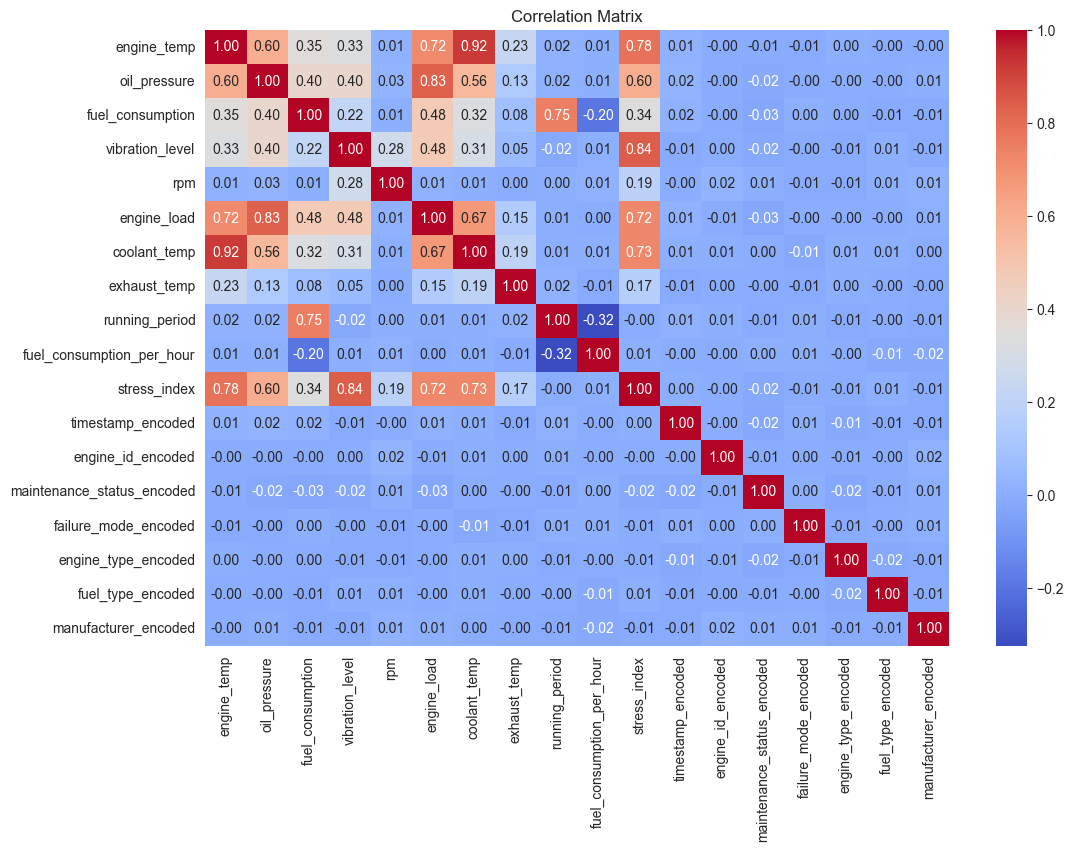

In [16]:
plt.figure(figsize=(12,8))  # Set figure size
sns.heatmap(
    df[numeric_cols].corr(),  # Correlation matrix of numeric columns
    annot=True,               # Show correlation values
    fmt=".2f",                # Format numbers to 2 decimals
    cmap='coolwarm'           # Color map
)
plt.title("Correlation Matrix")  # Add title
plt.show()                       # Display plot


## 9. Engine Performance Comparison by Type

To compare engine behavior across different engine types, a faceted scatter plot was created:

- **X-axis:** Engine temperature (`engine_temp`)
- **Y-axis:** Oil pressure (`oil_pressure`)
- **Bubble size:** Vibration level (`vibration_level`)
- **Facets:** Separate plots for each engine type for easy comparison
- **Opacity:** Reduced to 0.6 to improve readability in overlapping points

This visualization allows stakeholders to identify patterns and anomalies in engine performance across types, supporting targeted maintenance strategies.

In [17]:
import plotly.express as px

fig = px.scatter(df, 
                 x='engine_temp', 
                 y='oil_pressure', 
                 size='vibration_level',
                 hover_data=df.columns,
                 facet_col="engine_type",   # separate by engine type
                 facet_col_wrap=2,          # put subplots in 2 columns
                 opacity=0.6,               # reduce overlap
                 size_max=15,               # control bubble size
                 title="Engine Temp vs Oil Pressure by Engine Type")

fig.show()


## 10. Report Generation

A professional Excel report was generated to provide stakeholders with actionable insights. The report includes:

- **Full Data:** Complete processed telemetry data.
- **High-Risk Engines:** Engines flagged as anomalies.
- **Summary Statistics:** Descriptive statistics for all numeric metrics.
- **Engine Type Stats:** Aggregated statistics per engine type.

### Formatting and Highlights

- Headers were styled with a dark blue background and bold white font for readability.
- Conditional formatting applied to highlight critical metrics, e.g., `engine_temp` values using a red-yellow-green scale.
- High-risk engines were emphasized with a red fill and white bold text to draw attention.

This Excel report allows easy identification of high-risk engines and facilitates informed maintenance decisions.


In [18]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font
from openpyxl.formatting.rule import ColorScaleRule

# --- Save DataFrames to Excel ---
file_path = "engine_health_report.xlsx"
with pd.ExcelWriter(file_path, engine="openpyxl") as writer:
    df.to_excel(writer, sheet_name="Full Data", index=False)
    high_risk_engines.to_excel(writer, sheet_name="High-Risk Engines", index=False)
    summary_stats.to_excel(writer, sheet_name="Summary Statistics")
    engine_stats.to_excel(writer, sheet_name="Engine Type Stats")

# --- Apply formatting ---
wb = load_workbook(file_path)

# Style headers for all sheets
header_fill = PatternFill(start_color="1F4E78", end_color="1F4E78", fill_type="solid")
header_font = Font(color="FFFFFF", bold=True)

for sheet_name in wb.sheetnames:
    ws = wb[sheet_name]
    for cell in ws[1]:  # first row = header
        cell.fill = header_fill
        cell.font = header_font

# Conditional formatting for "Full Data" sheet
ws = wb["Full Data"]

# Example: highlight high engine_temp values in red/yellow/green
if "engine_temp" in df.columns:
    col_idx = list(df.columns).index("engine_temp") + 1  # +1 for Excel indexing
    cell_range = f"{chr(65+col_idx)}2:{chr(65+col_idx)}{len(df)+1}"
    ws.conditional_formatting.add(
        cell_range,
        ColorScaleRule(start_type="min", start_color="63BE7B",  # green
                       mid_type="percentile", mid_value=50, mid_color="FFEB84",  # yellow
                       end_type="max", end_color="F8696B")  # red
    )

# Conditional formatting for high-risk engines sheet
if "Predicted_Status" in high_risk_engines.columns or "maintenance_status" in high_risk_engines.columns:
    ws = wb["High-Risk Engines"]
    for col in ws.iter_cols(min_row=2, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
        for cell in col:
            cell.fill = PatternFill(start_color="F8696B", end_color="F8696B", fill_type="solid")
            cell.font = Font(color="FFFFFF", bold=True)

# Save final styled workbook
wb.save(file_path)

print(f"✅ Excel report saved as {file_path}")


✅ Excel report saved as engine_health_report.xlsx


## 11. Summary

This study focused on detecting failures in marine engines using telemetry data. The main outcomes include:

- **Data Cleaning & Preprocessing:** Handled missing values and standardized the dataset for analysis.
- **Feature Engineering:** Created a `stress_index` metric to quantify engine stress and potential failure risk.
- **Anomaly Detection:** Applied Isolation Forest to identify high-risk engines; anomalies were visualized over time and in scatter plots.
- **Statistical Analysis:** Computed summary statistics and correlations to understand failure drivers.
- **Visualization:** Explored engine behavior across types using faceted scatter plots and heatmaps.
- **Report Generation:** Produced a professional Excel report highlighting high-risk engines with conditional formatting for stakeholders.

This framework supports proactive maintenance, early detection of failures, and improved operational safety for marine vessels.




## References

Fijabi, J. A. (2023). *Preventive Maintenance for Marine Engines* [Dataset]. Kaggle. https://www.kaggle.com/datasets/jeleeladekunlefijabi/preventive-maintenance-for-marine-engines
